# Autoencoder training

In [21]:
import datetime
import json
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import scipy
import tensorflow as tf

from rich import print
from sys import platform
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Convolution2D, AvgPool2D, MaxPooling2D, Convolution2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten, Input, Rescaling
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, BinaryCrossentropy

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

%matplotlib inline

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f"GPUs available: {tf.config.list_physical_devices('GPU')}")

Num GPUs Available:  1

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.- Loading the dataset.

First, we need to load the images that will be used to train the autoencoder. The function _load_hdf5_files_ takes as inputs a direcotry path in which the hdf5 files with the images are stored, and the number of files to load within that directory. The files are randomly sampled. It returns three numpy arrays, that serve as train, validation and test datasets.

In [2]:
def load_hdf5_files(directory, n = None):
    """
    Load random HDF5 files containing images from a specified directory and concatenate them into a single NumPy array.

    Args:
        directory (str): The path to the directory containing HDF5 files.
        n (int): The number of random files to load.

    Returns:
        train_data: A  NumPy array containing all the images from the train dataset of the loaded HDF5 files.
        validation_data: A single NumPy array containing all the images from the validation dataset of the loaded HDF5 files.
        test_data: A single NumPy array containing all the images from the the test dataset of the loaded HDF5 files.

    The function selects 'n' random HDF5 files from the specified 'directory', reads the datasets from each
    file, and concatenates these datasets into a single NumPy array. This array contains all the images from the loaded
    HDF5 files. The function returns three arrays, one each for training, validation and test.

    Note:
    - Ensure that the HDF5 files in the directory have datasets named 'train', 'validation', and  'test' (or adjust accordingly).
    - If 'n' is greater than the number of available HDF5 files in the directory, all available files will be loaded.
    - if 'n' is not specified, all available files will be loaded

    Example usage:
    >>> directory_path = '/path/to/your/directory'
    >>> n = 3
    >>> train_data, val_data, test_data = load_random_hdf5_files(directory_path, n_files_to_load)
    """

    file_list = []
    # List all HDF5 files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".hdf5"):
            file_list.append(os.path.join(directory, filename))
    if not file_list:
        print("No HDF5 files found in the specified directory.")
        return None
    if (n > len(file_list)) or (n is None):
        print(f"Requested to load {n} files, but there are only {len(file_list)} files available.")
        n = len(file_list)

    # Randomly select n files
    random_files = random.sample(file_list, n)
    train_data = []
    validation_data = []
    test_data = []
    global_max = 0
    global_min = 1e6
    # return train_data, validation_data, test_data, metadata

    for file_path in random_files:
        with h5py.File(file_path, 'r') as hf:
            # Load train, validation, and test datasets
            d1 = np.array(hf["train"], dtype = np.uint8)
            d2 = np.array(hf["validation"])
            d3 = np.array(hf["test"])
            local_max = hf.attrs['train_max']
            local_min = hf.attrs['train_min']
            if local_max > global_max:
                global_max = local_max
            if local_min < global_min:
                global_min = local_min
            train_data.append(np.array(d1))
            validation_data.append(np.array(d2))
            test_data.append(np.array(d3))

    # Concatenate the individual arrays into a single NumPy array
    train_data = np.concatenate(train_data, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_data = np.concatenate(test_data, axis=0)

    img_shape = train_data[0].shape
    re_shape = (-1,) + img_shape + (1,)
    print("Sets will be of shape: {}".format(re_shape))
    print("Range scalers are (global min, global max) = {}".format([global_min, global_max]))
    train_data = train_data.reshape(re_shape)
    validation_data = validation_data.reshape(re_shape)
    test_data = test_data.reshape(re_shape)

    return train_data, validation_data, test_data, [global_min, global_max]

In [3]:
if platform == 'darwin':
    images_path = "/Users/lmiguelmartinez/Tesis/datasets/highD/images_1000ms"
else:
    images_path = "/home/lmmartinez/Tesis/datasets/highD/images_int"

train_data, val_data, test_data, global_scalers = load_hdf5_files(images_path, n = 10)
os.makedirs('/tmp/logs', exist_ok=True)
tensorboard_log_dir = '/tmp/logs/'
IMAGE_SIZE = train_data[0].shape
BATCH_SIZE = 256
print("Images are of size {}".format(IMAGE_SIZE))

Sets will be of shape: (-1, 121, 201, 1)

Range scalers are (global min, global max) = [0.0, 62.11032]

Images are of size (121, 201, 1)

### 1.1 Data Inspection

Once the data has been loaded, a few sample images are plotted to verify its integrity.

Total training  images: 143278

Total validation images: 47757

Total test images: 47769

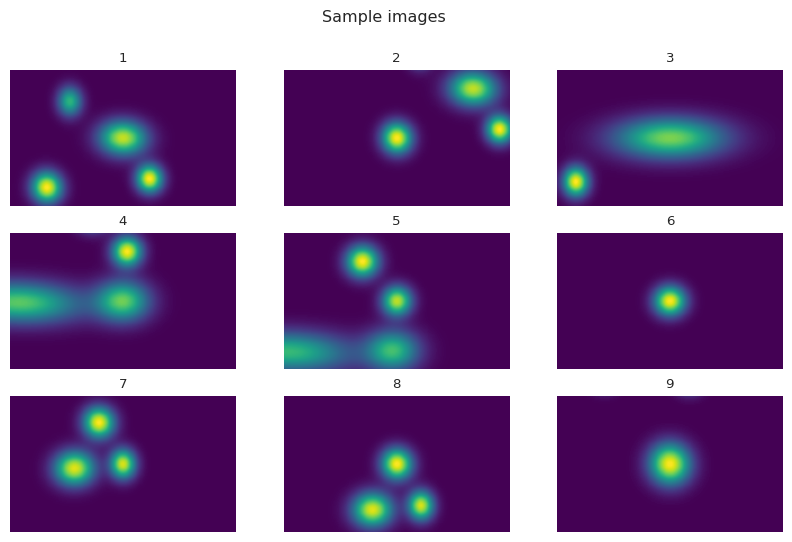

In [4]:
print('Total training  images:', len(train_data))
print('Total validation images:', len(val_data))
print('Total test images:', len(test_data))

plot_size = 3
pic_index = np.random.randint(plot_size, np.min([len(train_data), len(val_data), len(test_data)]))

next_train = [img for img in train_data[pic_index-plot_size:pic_index]]
next_val = [img for img in val_data[pic_index-plot_size:pic_index]]
next_test = [img for img in test_data[pic_index-plot_size:pic_index]]

plt.figure(figsize=(10, 6))
for i, img in enumerate(next_train+next_val+next_test):
    plt.subplot(3, plot_size, i+1)
    plt.imshow(img, cmap = 'viridis')
    plt.title(i+1)
    plt.axis('Off')
plt.suptitle("Sample images")
plt.show()

## 2.- Model definition.

To define the autoencoder we will use four dictionaries: encoder-decoder architecture, training configuration and model parameters. The class AutoEncoder implements the necessary steps to train the Autoencoder and perform validation and testing tasks.

In [73]:
class AutoEncoder:
    def __init__(self, train_config = None, model_config = None, encoder_config = None, decoder_config = None):
        """
        Initialize an AutoEncoder instance.

        Args:
            train_config (dict): Configuration for training the model.
            model_config (dict): Configuration for the autoencoder model.
            encoder_config (dict): Configuration for the encoder part of the autoencoder.
            decoder_config (dict): Configuration for the decoder part of the autoencoder.
        """
        self.train_config = train_config
        self.encoder_config = encoder_config
        self.decoder_config = decoder_config
        self.model_config = model_config

        self.encoder = None
        self.decoder = None
        self.model = None

    def buildModel(self, arch_config = None):
        """
        Build a Keras model based on the provided architecture configuration.

        Args:
            arch_config (dict): Configuration for the architecture of the model.

        Returns:
            tf.keras.models.Sequential: The constructed Keras model.
        """
        model = Sequential()
        for layer in arch_config.keys():
            layer_identifier = re.split('_',layer)[0]
            arch_config[layer]['name'] = layer
            if (layer_identifier == 'Input'):
                continue
            elif (layer_identifier == 'LSTM'):
                x = LSTM(**arch_config[layer])
            elif (layer_identifier == 'GRU'):
                x = GRU(**arch_config[layer])
            elif (layer_identifier == 'Conv2D'):
                x = Convolution2D(**arch_config[layer])
            elif (layer_identifier == 'Deconv2D'):
                x = Convolution2DTranspose(**arch_config[layer])
            elif (layer_identifier == 'MaxPooling2D'):
                x = MaxPooling2D(**arch_config[layer])
            elif(layer_identifier == 'AvgPooling2D'):
                x = AvgPool2D(**arch_config[layer])
            elif (layer_identifier == 'Dense'):
                x = MaxPooling2D(**arch_config[layer])
            elif (layer_identifier == 'Flatten'):
                x = Flatten()
            elif (layer_identifier == 'Dropout'):
                x = Dropout(**arch_config[layer])
            elif (layer_identifier == 'BatchNormalization'):
                x = BatchNormalization(**arch_config[layer])
            elif (layer_identifier == 'Rescaling'):
                x = Rescaling(**arch_config[layer])
            model.add(x)
        return model
    
    def buildAutoencoder(self):
        """
        Build the autoencoder model using the encoder and decoder configurations.
        """
        self.encoder = self.buildModel(arch_config=self.encoder_config)
        self.decoder = self.buildModel(arch_config=self.decoder_config)

        input_tensor = Input(shape=self.encoder_config['Input_1']['shape'])
        latent_vector = self.encoder(input_tensor)
        output = self.decoder(latent_vector)
        self.model = Model(input_tensor, output)
        self.compileModel()
        
    def compileModel(self):
        """
        Compile the autoencoder model with the specified loss function and optimizer.
        """
        loss_fun = self.model_config['loss']
        opt = self.model_config['opt']
        name = self.model_config['name']
        metrics = self.model_config['metrics']

        print("Loss, optimizer and metric set up")
        self.model._name = name
        self.model.compile(loss = loss_fun, optimizer = opt, metrics = metrics)
        print("Model created:")
        self.model.summary()
        print("Model has been built")

    def trainModel(self, train_data, val_data, log_dir):
        """
        Train the autoencoder model using the provided training data.

        Args:
            train_data (numpy.ndarray): Training data.
            val_data (numpy.ndarray): Validation data.
            log_dir (str): Directory for TensorBoard logs.

        Returns:
            dict: Training history.
        """
        batch_size = self.train_config['batch_size']
        epochs = self.train_config['epochs']
        shuffle = self.train_config['shuffle']
        patience = self.train_config['ES_patience']
        min_delta = self.train_config['ES_min_delta']
        verbose = self.train_config['verbose']
        start_from = self.train_config['start_from_epoch']
        
        checkpoint_path = os.path.join(log_dir, "model_checkpoint.h5")
        checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)

        early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        verbose=1,
        min_delta = min_delta,
        start_from_epoch = start_from,
        restore_best_weights = True)

        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=4)

        history = self.model.fit(
            x=train_data,
            y=train_data,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            validation_data=(val_data, val_data),
            shuffle=shuffle,
            callbacks=[checkpoint, early_stopping, tensorboard_callback],
            steps_per_epoch=None,
            validation_freq=1,
        )
        self.history = history.history

        return self.history

    def predict(self, test_set):
        """
        Generate predictions using the trained autoencoder model.

        Args:
            test_set (numpy.ndarray): Input data for making predictions.

        Returns:
            numpy.ndarray: Predicted output.
        """
        predictions = self.model.predict(test_set)
        return predictions
    
    def compare(self, test_set, num_plots = 3):
        """
        Compare original input data with reconstructed data and display the results.

        Args:
            test_set (numpy.ndarray): Test data for comparison.
            num_plots (int): Number of plots to generate for comparison.
        """
        idxs = np.random.choice(range(len(test_set)), size=num_plots)
        print(idxs)
        test_samples = np.take(test_set, idxs, axis = 0)
        predictions = self.predict(test_samples)
        
        for (img, prediction, index) in zip(test_samples, predictions, idxs):
            fig, (ax1, ax2, ax3) = plt.subplots(3,1)
            fig.set_figheight(6)
            fig.set_figwidth(8)
            # ax1 = fig.add_subplot(1, 3, 1)
            pl1 = ax1.imshow(img, cmap = 'viridis', aspect = 'auto')
            ax1.set_title("Original field")
            ax1.set_xlabel("Longitudinal coordinate")
            ax1.set_ylabel("Transversal coordinate")
            ax1.axis('Off')
            fig.colorbar(pl1, orientation = 'vertical', pad = 0.1)

            # ax2 = fig.add_subplot(1, 3, 2)
            pl2 = ax2.imshow(prediction, cmap = 'viridis', aspect = 'auto')
            ax2.set_title("Reconstructed field")
            ax2.set_xlabel("Longitudinal coordinate")
            ax2.set_ylabel("Transversal coordinate")
            ax2.axis('Off')
            fig.colorbar(pl2, orientation = 'vertical', pad = 0.1)

            # ax3 = fig.add_subplot(1, 3, 3)
            pl3 = ax3.imshow(np.subtract(img, prediction), cmap = 'seismic', aspect = 'auto')
            ax3.set_title("Reconstruction error")
            ax3.set_xlabel("Longitudinal coordinate")
            ax3.set_ylabel("Transversal coordinate")
            ax3.axis('Off')
            fig.colorbar(pl3, orientation = 'vertical', pad = 0.1)

            fig.suptitle("Images and predictions from test set - Index {}".format(index))
            fig.tight_layout()
            plt.show()

    def save_model(self, directory, file_name):
        """
        Save the trained model and configuration dictionaries to files in the specified directory.

        Args:
            directory (str): Directory path for saving files.
            file_name (str): Base name for saved files (without extension). If None, a default name will be generated.
        """
        def is_jsonable(x):
            try:
                json.dumps(x)
                return True
            except (TypeError, OverflowError):
                return False
        # Create the directory if it doesn't exist
        if not os.path.exists(directory):
            print(f"Directory {directory} does not exist. Creating...")
            os.makedirs(directory)

        if file_name is None:
            # Generate a default name based on the current date and time
            timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
            file_name = f"autoencoder_{timestamp}"
            
        # Save the model to a keras file
        model_file_path = os.path.join(directory, f"{file_name}.h5")
        self.model.save(model_file_path)

        # Combine all dictionaries into a single dictionary
        all_data = {
            "model_config": self.model_config,
            "encoder_config": self.encoder_config,
            "decoder_config": self.decoder_config,
            "train_config": self.train_config,
            "history": self.history if self.history else None
        }

        #Convert everything to string so that its json serializable
        for outer_key, outer_value in all_data.items():
            for inner_key, inner_value in outer_value.items():
                if not (is_jsonable(inner_value)):
                    all_data[outer_key][inner_key] = str(inner_value)

        # Save the combined dictionary as a JSON file
        configs_file = os.path.join(directory, f"{file_name}_configs.json")
        with open(configs_file, 'w') as f:
            json.dump(all_data, f, indent=4)

        print(f"Model and configs saved to {directory}")
      
        
    def plot_history(self):
        """
        Plot the training and validation loss, RMSE, and MAE over epochs.
        """
        def smooth(scalars, weight):  # Weight between 0 and 1
            last = scalars[0]  # First value in the plot (first timestep)
            smoothed = list()
            for point in scalars:
                smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
                smoothed.append(smoothed_val)                        # Save it
                last = smoothed_val                                  # Anchor the last smoothed value
            return smoothed
        epochs = list(range(len(self.history['loss'])))
        loss = self.history['loss']
        val_loss = self.history['val_loss']
        mae = self.history.get('mean_absolute_error', None)
        val_mae = self.history.get('val_mean_absolute_error', None)
        rmse = self.history.get('root_mean_squared_error', None)
        val_rmse = self.history.get('val_root_mean_squared_error', None)
        binary_crossentropy = self.history.get('binary_crossentropy', None)
        val_binary_crossentropy = self.history.get('val_binary_crossentropy', None)

        plt.figure(figsize=(15,8))
        plt.subplot(2, 2, 1)
        plt.title('Loss - MSE')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(epochs ,loss, label='Training loss', linestyle='--', alpha = 0.5, color = 'purple')
        plt.plot(epochs, val_loss, label='Validation loss', linestyle='--', alpha = 0.5, color = 'orange')
        plt.plot(epochs, smooth(scalars=loss, weight=0.6), label = 'Smoothed training loss', color = 'purple')
        plt.plot(epochs, smooth(scalars=val_loss, weight=0.6), label = 'Smoothed validation loss', color = 'orange')
        plt.legend()
        plt.grid(linestyle='--', linewidth=1, alpha=0.5)

        if mae is not None:
            plt.subplot(2, 2, 2)
            plt.title('Mean Absolute Error (MAE)')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.plot(epochs, mae, label='Training loss', linestyle='--', alpha = 0.5, color = 'purple')
            plt.plot(epochs, val_mae, label='Validation loss', linestyle='--', alpha = 0.5, color = 'orange')
            plt.plot(epochs, smooth(scalars=mae, weight=0.6), label = 'Smoothed training loss', color = 'purple')
            plt.plot(epochs, smooth(scalars=val_mae, weight=0.6), label = 'Smoothed validation loss', color = 'orange')
            plt.legend()
            plt.grid(linestyle='--', linewidth=1, alpha=0.5)
        if rmse is not None:
            plt.subplot(2, 2, 3)
            plt.title('Root Mean Squared Error (RMSE)')
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.plot(epochs, rmse, label='Training loss', linestyle='--', alpha = 0.5, color = 'purple')
            plt.plot(epochs, val_rmse, label='Validation loss', linestyle='--', alpha = 0.5, color = 'orange')
            plt.plot(epochs, smooth(scalars=rmse, weight=0.6), label = 'Smoothed training loss', color = 'purple')
            plt.plot(epochs, smooth(scalars=val_rmse, weight=0.6), label = 'Smoothed validation loss', color = 'orange')
            plt.legend()
            plt.grid(linestyle='--', linewidth=1, alpha=0.5)
        if binary_crossentropy is not None:
            plt.subplot(2, 2, 4)
            plt.title('Binary Crossentropy (BC)')
            plt.xlabel('Epoch')
            plt.ylabel('BC')
            plt.plot(epochs, binary_crossentropy, label='Training loss', linestyle='--', alpha = 0.5, color = 'purple')
            plt.plot(epochs, val_binary_crossentropy, label='Validation loss', linestyle='--', alpha = 0.5, color = 'orange')
            plt.plot(epochs, smooth(scalars=binary_crossentropy, weight=0.6), label = 'Smoothed training loss', color = 'purple')
            plt.plot(epochs, smooth(scalars=val_binary_crossentropy, weight=0.6), label = 'Smoothed validation loss', color = 'orange')
            plt.legend()
            plt.grid(linestyle='--', linewidth=1, alpha=0.5)
        
        plt.tight_layout()
        plt.show()

Some important formulas: 
- Output size of convolution layer: $(W_o, H_o) = (\frac{W-K_x+2P_x}{S_x} + 1 ,  \frac{W-K_y+2P_y}{S_y} + 1 )$

- Output size of deconvoltion layer: $(W_o, H_o) = (S_x \cdot (W-1) + K_x - 2P_x, \quad S_y \cdot (H-1) + K_y - 2P_y)$

- Output size of pooling layer: $(W_o, H_o) = (\frac{W-K_x}{S_x} + 1 ,  \frac{W-K_y}{S_y} + 1 )$

In [8]:
model_config = {'name': "AutoEncoder1", 'loss': 'mean_squared_error', 'opt': 'adam', 'metrics': [RootMeanSquaredError(), MeanAbsoluteError(), BinaryCrossentropy()]}

encoder_config = {
    'Input_1': {'shape': train_data[0].shape},
    'Rescaling_10': {'scale': 1./255, 'offset': 0.0},
    'Conv2D_11': {'filters': 32, 'kernel_size': (5,5), 'padding': 'same', 'strides': (3,3), 'activation': 'relu'},
    'MaxPooling2d_12': {'pool_size': (5,5), 'padding': 'same', 'strides': (3,3)},
    'Conv2D_13': {'filters': 16, 'kernel_size': (3,3), 'padding': 'same', 'strides': (3,3), 'activation': 'relu'},
    'MaxPooling2d_12': {'pool_size': (7,7), 'padding': 'same', 'strides': (3,3)},
    'Conv2D_15': {'filters': 4, 'kernel_size': (3,3), 'padding': 'same', 'strides': (3,3), 'activation': 'relu'},
}

decoder_config = {
    'Deconv2D_21': {'filters': 4, 'kernel_size': (3,3), 'padding': 'same', 'strides': (3, 3), 'activation': 'relu'},
    'Deconv2D_22': {'filters': 8, 'kernel_size': (3,3), 'padding': 'same', 'strides': (3,3), 'activation': 'relu'},
    'Deconv2D_23': {'filters': 32, 'kernel_size': (3,3), 'padding': 'same', 'strides': (3,3), 'activation': 'relu'},
    'Conv2D_24': {'filters': 1, 'kernel_size': (15,16), 'padding': 'valid', 'strides': (1,1), 'activation': 'relu'}
}


train_config = {'batch_size': BATCH_SIZE, 'epochs': 200, 'shuffle': True, 'ES_patience': 4, 'ES_min_delta': 1, 'verbose': 1, 'start_from_epoch': 2}

autoencoder = AutoEncoder(model_config=model_config, train_config=train_config, encoder_config=encoder_config, decoder_config=decoder_config)
autoencoder.buildAutoencoder()
# autoencoder.encoder.summary()
# autoencoder.decoder.summary()

2023-11-04 12:28:45.507375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 12:28:45.507618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 12:28:45.507751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loss, optimizer and metric set up

Model created:

Model: "AutoEncoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 121, 201, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 5, 8, 4)           6036      
                                                                 
 sequential_1 (Sequential)   (None, 121, 201, 1)       10461     
                                                                 
Total params: 16497 (64.44 KB)
Trainable params: 16497 (64.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model has been built

In [9]:
history = autoencoder.trainModel(train_data=train_data, val_data=val_data, log_dir=tensorboard_log_dir)

2023-11-04 12:28:49.415845: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3484664238 exceeds 10% of free system memory.
2023-11-04 12:28:52.041492: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3484664238 exceeds 10% of free system memory.
2023-11-04 12:28:54.158149: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3484664238 exceeds 10% of free system memory.
2023-11-04 12:28:55.879826: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3484664238 exceeds 10% of free system memory.


Epoch 1/200


2023-11-04 12:29:00.006446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-04 12:29:25.874197: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f342000f220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-04 12:29:25.874215: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2023-11-04 12:29:25.880508: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-04 12:29:25.971126: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


560/560 [==============================] - 123s 167ms/step - loss: 184.6308 - root_mean_squared_error: 13.5879 - mean_absolute_error: 5.4502 - binary_crossentropy: -251.4630 - val_loss: 10.1762 - val_root_mean_squared_error: 3.1900 - val_mean_absolute_error: 1.6068 - val_binary_crossentropy: -245.6998
Epoch 2/200
  1/560 [..............................] - ETA: 1:01 - loss: 12.5333 - root_mean_squared_error: 3.5402 - mean_absolute_error: 1.7723 - binary_crossentropy: -277.1231

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


560/560 [==============================] - 70s 125ms/step - loss: 9.6989 - root_mean_squared_error: 3.1143 - mean_absolute_error: 1.5393 - binary_crossentropy: -262.4756 - val_loss: 7.3635 - val_root_mean_squared_error: 2.7136 - val_mean_absolute_error: 1.3475 - val_binary_crossentropy: -245.8080
Epoch 3/200
560/560 [==============================] - 70s 126ms/step - loss: 7.8912 - root_mean_squared_error: 2.8091 - mean_absolute_error: 1.3685 - binary_crossentropy: -262.5628 - val_loss: 6.3601 - val_root_mean_squared_error: 2.5219 - val_mean_absolute_error: 1.2375 - val_binary_crossentropy: -245.8831
Epoch 4/200
560/560 [==============================] - 70s 126ms/step - loss: 6.8817 - root_mean_squared_error: 2.6233 - mean_absolute_error: 1.2480 - binary_crossentropy: -262.6147 - val_loss: 5.5842 - val_root_mean_squared_error: 2.3631 - val_mean_absolute_error: 1.1396 - val_binary_crossentropy: -245.9132
Epoch 5/200
560/560 [==============================] - 70s 126ms/step - loss: 6.28

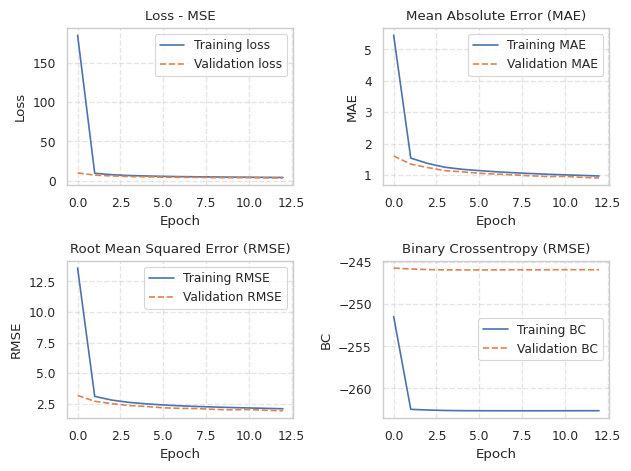

In [10]:
autoencoder.plot_history()

In [15]:
def load_model(model_name, directory='./saved_models'):
    """
    Load a trained model, configuration dictionaries, and training history from a directory.

    Args:
        model_name (str): Base name of the saved files (without extension).
        directory (str): Directory path where the model and configuration files are located.

    Returns:
        AutoEncoder: An AutoEncoder instance with the loaded model and configurations.
    """
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist. Unable to load model, configurations, and training history.")
        return None

    # Load the model from the h5 file
    model_file_path = os.path.join(directory, f"{model_name}.h5")
    if not os.path.exists(model_file_path):
        print(f"Model file {model_file_path} does not exist. Unable to load the model.")
        return None
    loaded_model = keras.models.load_model(model_file_path)

    # Load the configuration dictionaries and training history from the JSON file
    configs_file = os.path.join(directory, f"{model_name}_configs.json")
    if not os.path.exists(configs_file):
        print(f"Configurations file {configs_file} does not exist. Unable to load the configurations.")
        return None

    with open(configs_file, 'r') as f:
        all_data = json.load(f)

    # Create an AutoEncoder instance with the loaded model and configurations
    loaded_autoencoder = AutoEncoder()
    loaded_autoencoder.model = loaded_model
    loaded_autoencoder.model_config = all_data["model_config"]
    loaded_autoencoder.encoder_config = all_data["encoder_config"]
    loaded_autoencoder.decoder_config = all_data["decoder_config"]
    loaded_autoencoder.train_config = all_data["train_config"]
    loaded_autoencoder.history = all_data["history"]

    # #convert history from string to list of floats
    # for key, value in loaded_autoencoder.history.items():
    #     loaded_autoencoder.history[key] = eval(value)

    print(f"Model, configurations, and training history loaded from {directory}/{model_name}")
    return loaded_autoencoder


In [23]:
directory = './saved_models'
file_name = 'autoencoder_test_int_1'
autoencoder.save_model(directory=directory, file_name=file_name)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and configs saved to ./saved_models

In [74]:
del autoencoder
autoencoder = load_model(model_name=file_name, directory=directory)

Model, configurations, and training history loaded from ./saved_models/autoencoder_test_int_1

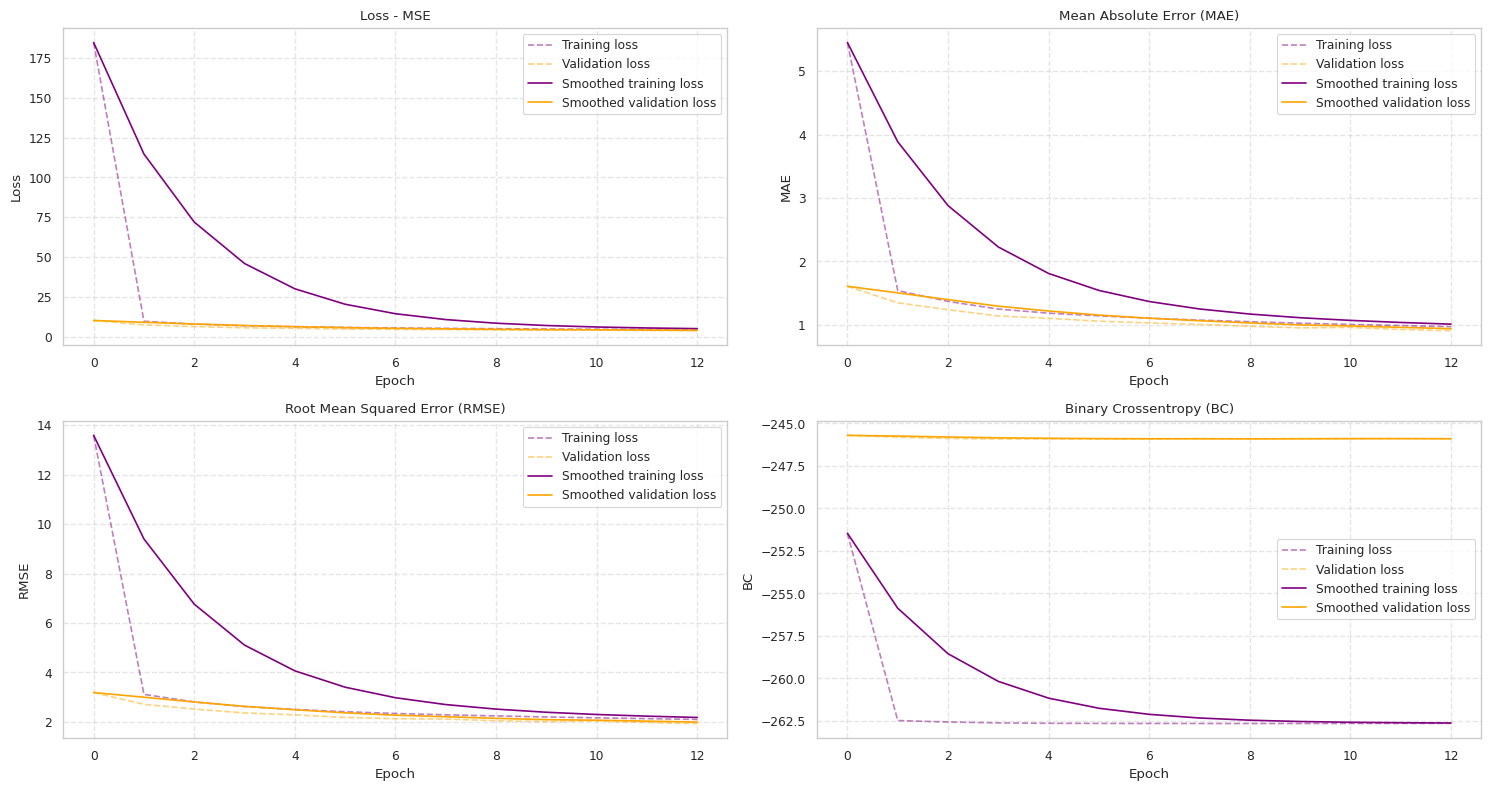

In [75]:
autoencoder.plot_history()

[40674 26270 40613 18145 31068]

1/1 [==============================] - 0s 15ms/step


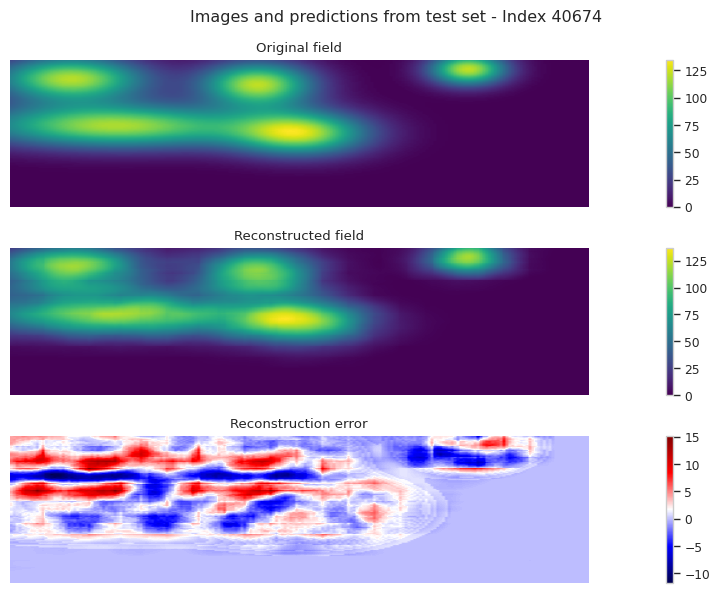

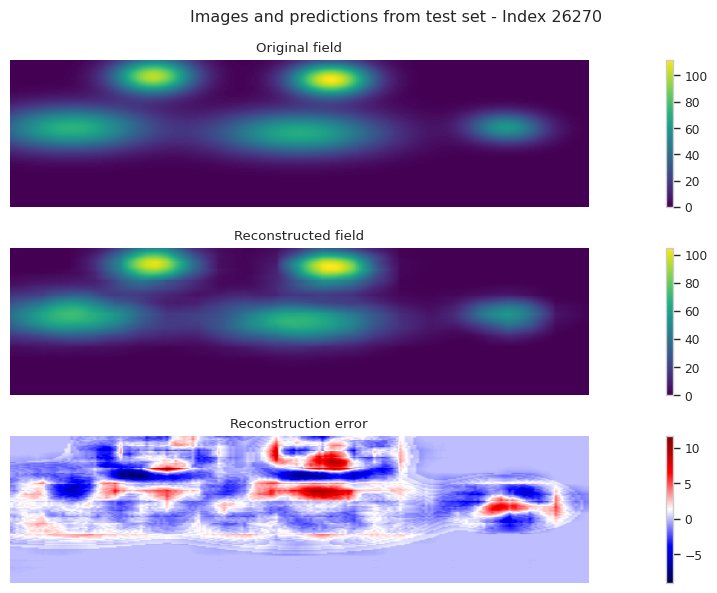

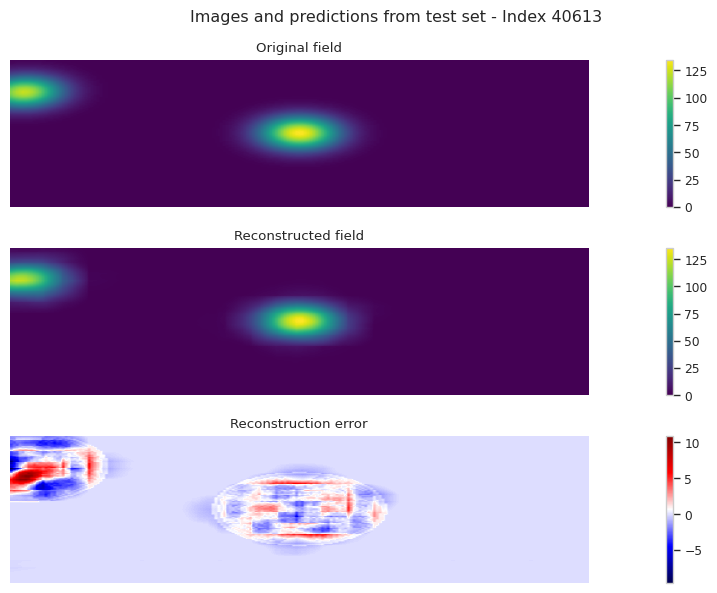

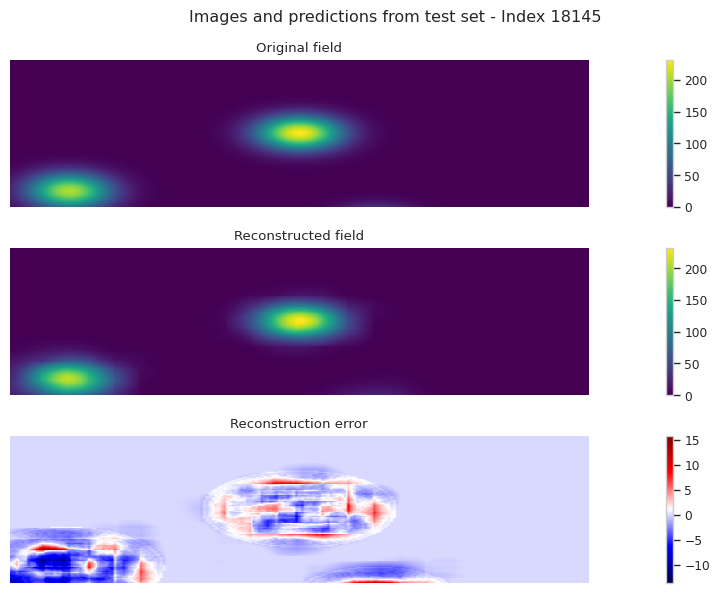

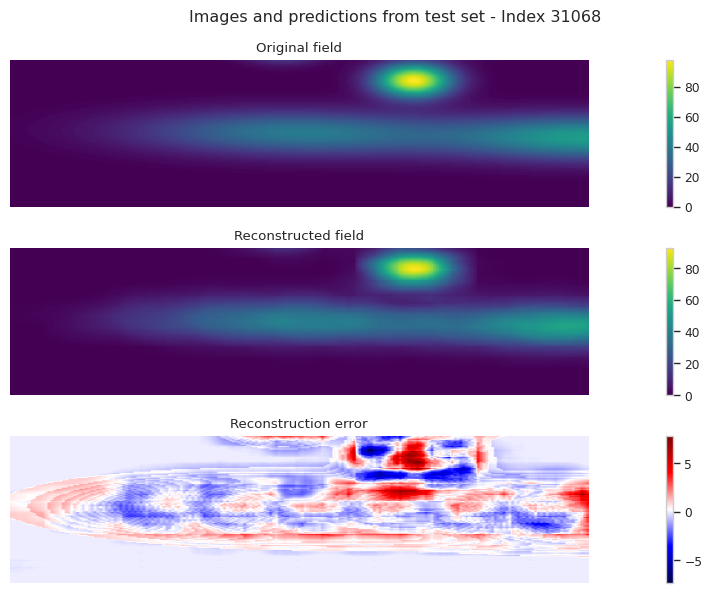

In [78]:
autoencoder.compare(val_data, num_plots=5)